In [11]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!

**Drive**

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**HelperFunction**

In [13]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

#visualize gradientgradient
def make_grad_hook():
    grads = []
    def grad_hook(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            grads.append(m.weight.grad)
    return grads, grad_hook

def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

**Generator**

In [14]:
def make_gen_block(input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
    if not final_layer:
        return nn.Sequential(
            nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True),
        )
    else:
        return nn.Sequential(
            nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
            nn.Tanh(),
        )

class Generator(nn.Module):
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            make_gen_block(z_dim, hidden_dim * 4),
            make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            make_gen_block(hidden_dim * 2, hidden_dim),
            make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def forward(self, noise):
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

**Critic**

In [15]:
def make_critic_block(input_chan,output_chan,kernel_size=4,stride=2,final_layer=False):
    if not final_layer:
        return nn.Sequential(
            nn.Conv2d(input_chan,output_chan,kernel_size,stride=stride),
            nn.BatchNorm2d(output_chan),
            nn.LeakyReLU(0.2,inplace=True)
        )
    else:
        return nn.Sequential(
            nn.Conv2d(input_chan,output_chan,kernel_size,stride=stride)
        )

class Critic(nn.Module):
    def __init__(self,im_chan=1,hidden_chan=16):
        super(Critic,self).__init__()
        self.critic = nn.Sequential(
            make_critic_block(im_chan,hidden_chan),
            make_critic_block(hidden_chan,hidden_chan * 2),
            #make_disc_block(hidden_chan * 2,hidden_chan * 4),
            make_critic_block(hidden_chan * 2,1,final_layer=True),
        )
    
    def forward(self,img):
        disc_pred = self.critic(img)
        return disc_pred.view(len(disc_pred), -1)

**Initialize Component**

In [16]:
#set hyperparameter
z_dim = 64
batch_size = 128
n_epochs = 200
display_step = 500
lr = 0.0002
beta_1 = 0.5 
beta_2 = 0.999
g_weight = 10
n_critic = 5

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

#convert data to tensor
dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size = batch_size,
    shuffle = True
)

#set device
device = 'cuda'

In [17]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
critic = Critic().to(device) 
critic_opt = torch.optim.Adam(critic.parameters(), lr=lr, betas=(beta_1, beta_2))

# You initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
critic = critic.apply(weights_init)

**GradientPenalty - handle mode collapsed**

In [18]:
def get_gradient(crit, real, fake, epsilon):
    mixed_images = epsilon * real + (1 - epsilon) * fake
    mixed_scores = crit(mixed_images)
    gradient = torch.autograd.grad(
        inputs=mixed_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient

def gradient_penalty(gradient):
    #flatten gradient
    gradient = gradient.view(len(gradient),-1)

    #get norm2 every row
    gradient_norm = gradient.norm(2,dim=1)

    #get penalty score with label 1
    penalty = torch.mean((gradient_norm - 1) ** 2)

    return penalty

**Loss method**

In [19]:
def get_gen_loss(crit_fake_pred):
    return -1.0 * torch.mean(crit_fake_pred)

def get_critic_loss(crit_real_pred,crit_fake_pred,gp,g_weight):
    return torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + gp * g_weight

**Training**

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, step 500: Generator loss: 0.6736873035127646, critic loss: -18.068124821954967


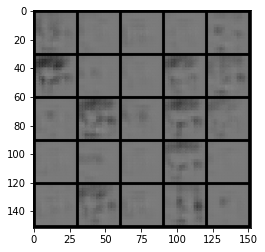

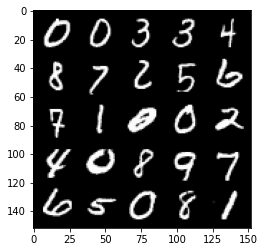

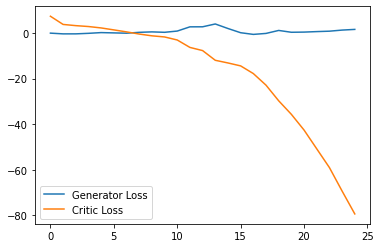

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2, step 1000: Generator loss: -0.22514820009469985, critic loss: -213.39492011108396


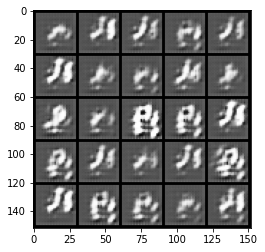

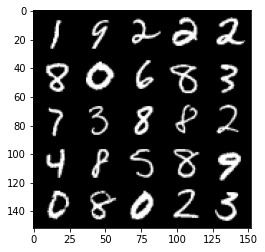

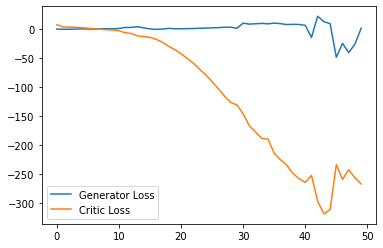

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3, step 1500: Generator loss: -7.293373541474343, critic loss: -255.776511236572


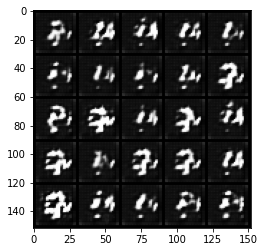

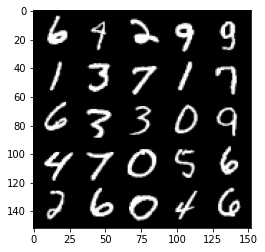

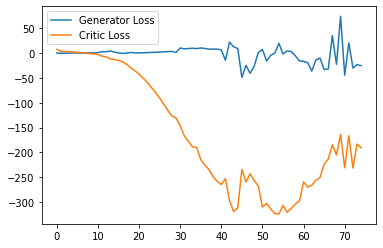

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4, step 2000: Generator loss: 26.307604588925837, critic loss: -191.35993986930865


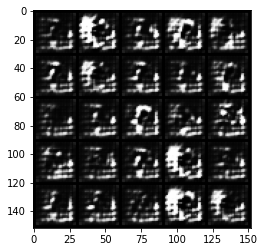

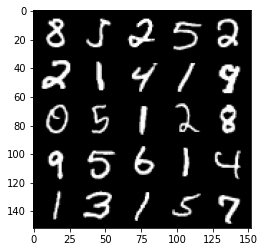

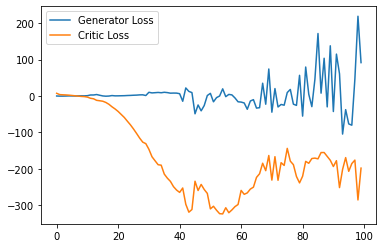

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5, step 2500: Generator loss: -10.901656182408333, critic loss: -239.5679107479097


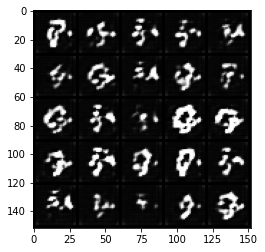

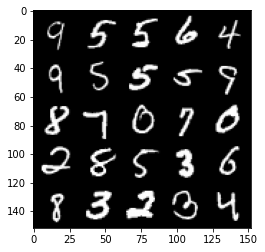

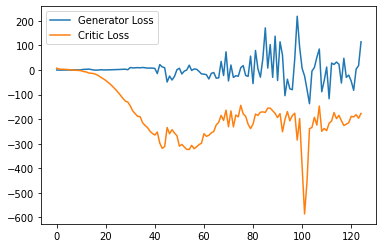

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6, step 3000: Generator loss: 45.389298505663874, critic loss: -197.79113335685747


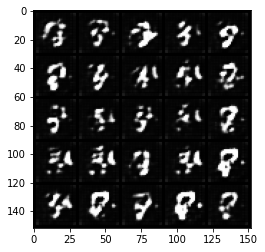

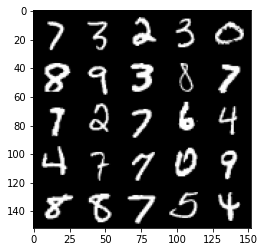

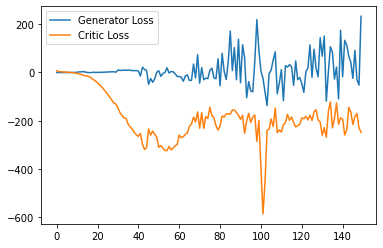

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7, step 3500: Generator loss: 28.3070037971735, critic loss: -181.95740735664353


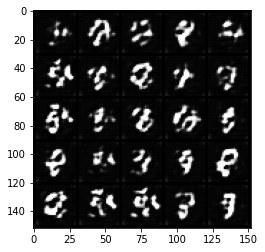

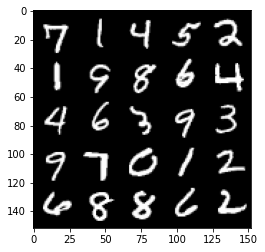

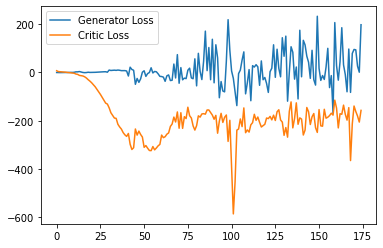

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8, step 4000: Generator loss: 36.00710427331924, critic loss: -193.82106256103515


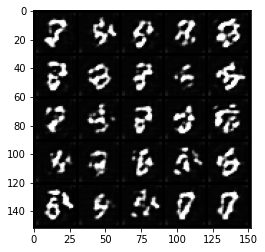

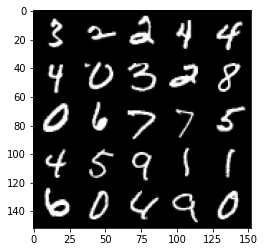

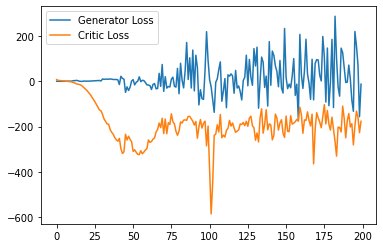

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9, step 4500: Generator loss: 19.025793230295182, critic loss: -209.58247260208134


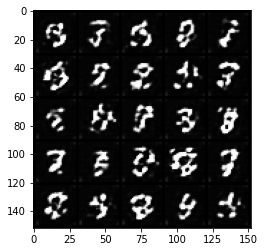

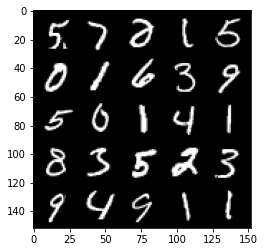

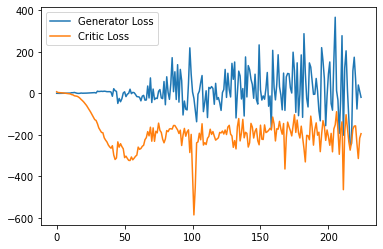

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10, step 5000: Generator loss: 89.75730908870698, critic loss: -244.43472537269605


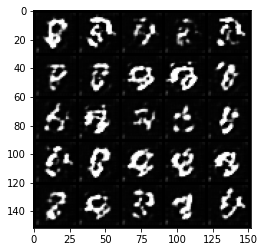

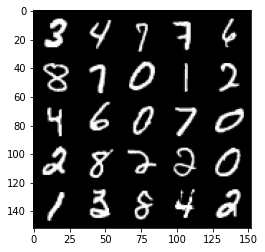

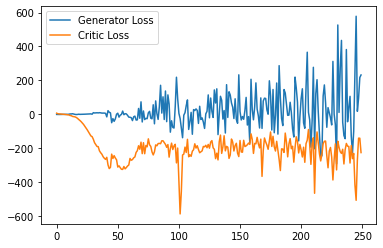

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 11, step 5500: Generator loss: 88.95542159986496, critic loss: -179.93988597450237


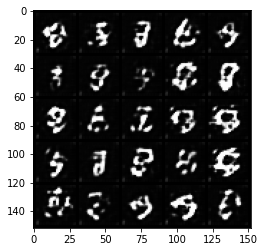

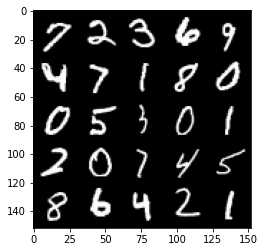

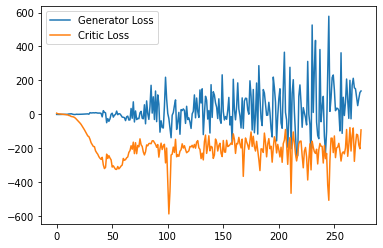

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 12, step 6000: Generator loss: 53.19506705069542, critic loss: -190.35227796897897


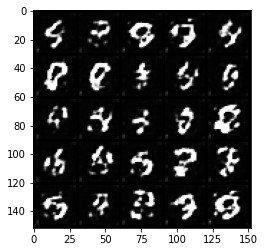

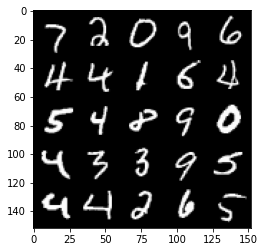

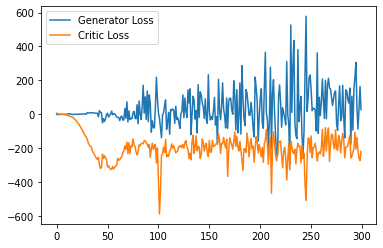

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 13, step 6500: Generator loss: 113.35624437642097, critic loss: -209.1081472782138


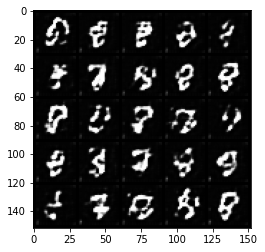

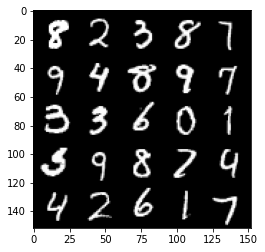

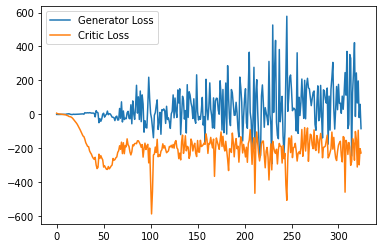

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 14, step 7000: Generator loss: 80.68116140532494, critic loss: -211.55879472579952


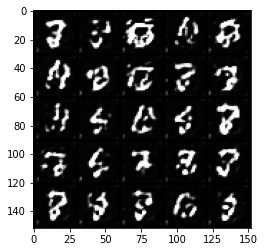

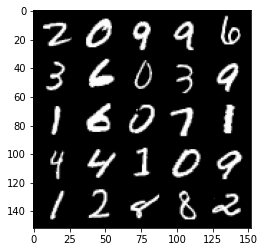

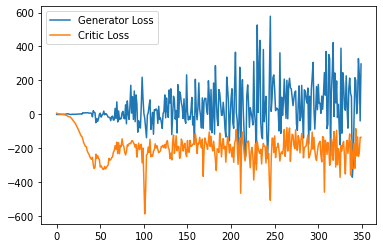

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 15, step 7500: Generator loss: 80.33428936648369, critic loss: -180.7882606651307


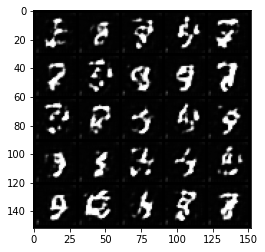

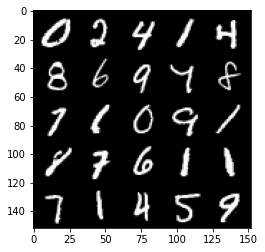

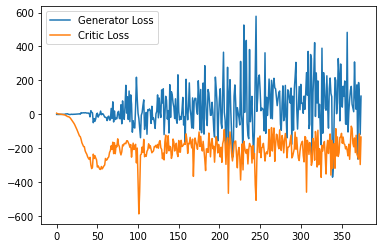

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 17, step 8000: Generator loss: 97.32882051706314, critic loss: -219.0560338928222


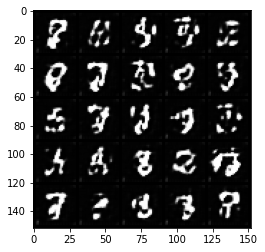

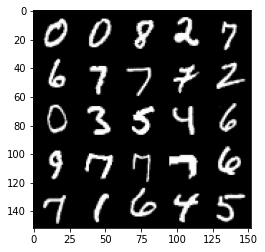

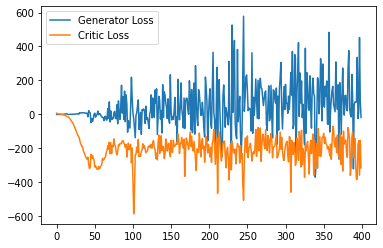

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 18, step 8500: Generator loss: 141.33896425294876, critic loss: -195.13747277793863


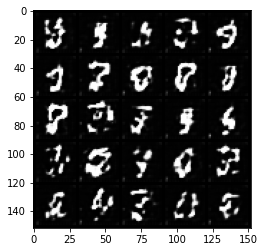

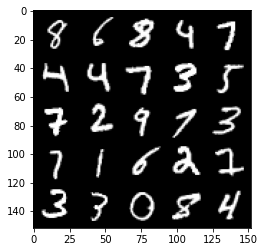

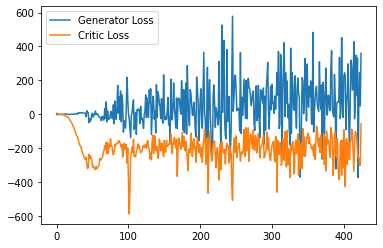

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 19, step 9000: Generator loss: 73.81076151156425, critic loss: -218.25278920021066


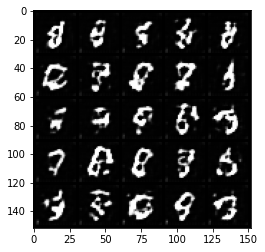

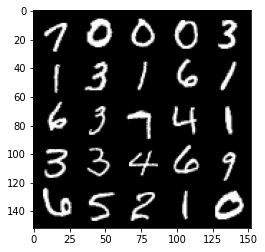

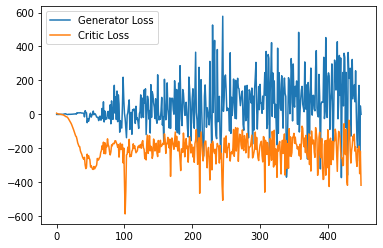

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 20, step 9500: Generator loss: 179.4138505870104, critic loss: -212.91665437965403


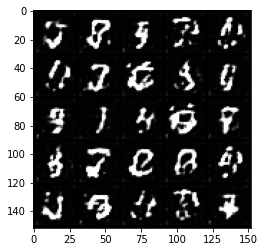

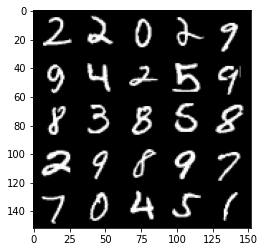

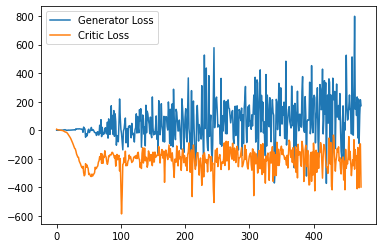

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 21, step 10000: Generator loss: 140.3039631679058, critic loss: -195.71401685485858


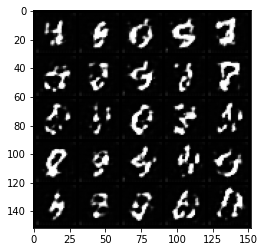

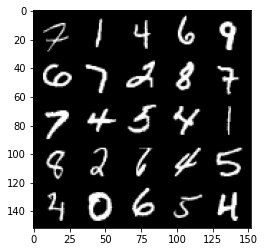

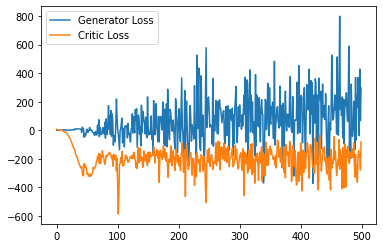

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 22, step 10500: Generator loss: 150.26006202602386, critic loss: -214.5588186767577


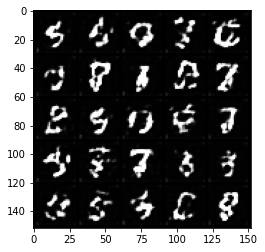

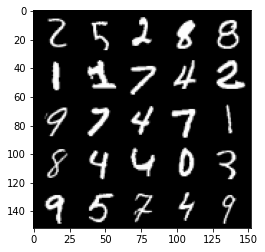

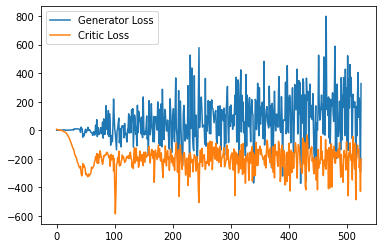

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 23, step 11000: Generator loss: 168.6943754068613, critic loss: -204.4111893623351


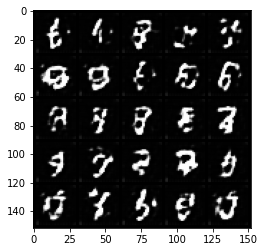

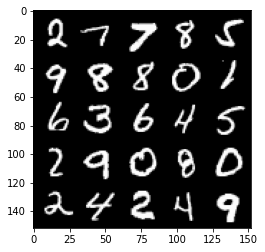

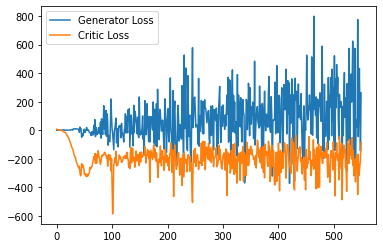

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 24, step 11500: Generator loss: 126.37609259843826, critic loss: -175.11455423126222


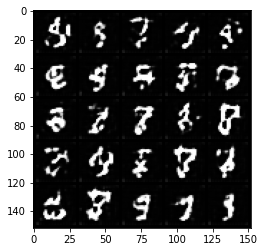

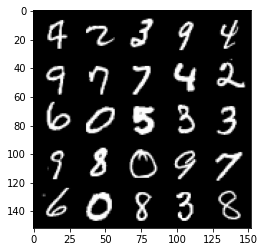

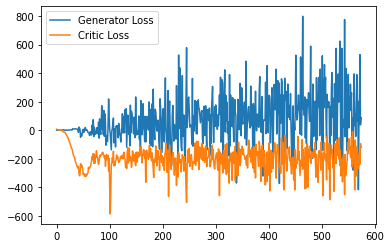

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 25, step 12000: Generator loss: 148.6583413939476, critic loss: -223.1368644641873


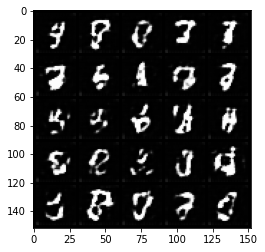

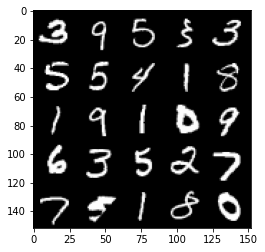

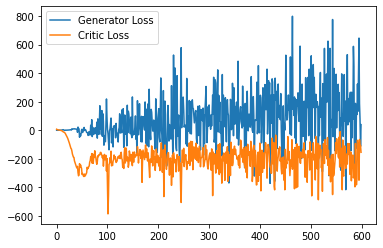

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 26, step 12500: Generator loss: 123.89615544176101, critic loss: -237.27902500457745


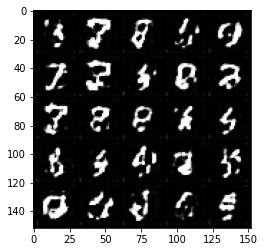

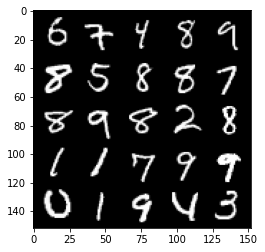

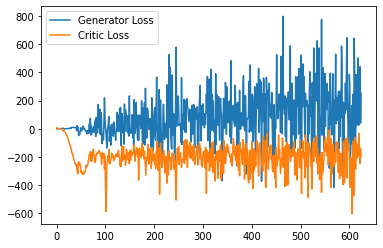

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 27, step 13000: Generator loss: 151.41667167043687, critic loss: -195.14932532310482


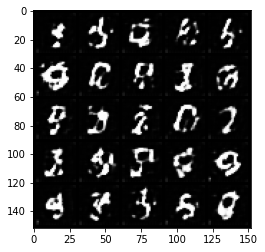

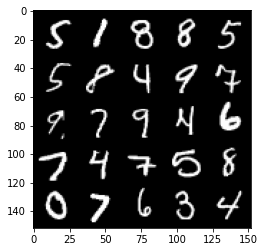

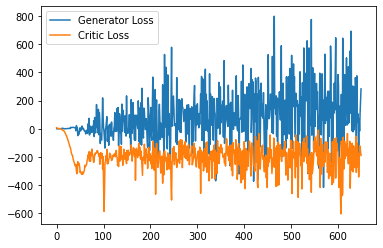

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 28, step 13500: Generator loss: 233.6178758864403, critic loss: -174.31347592926014


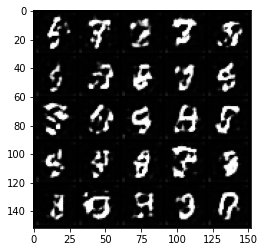

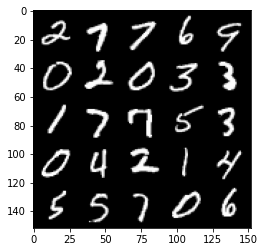

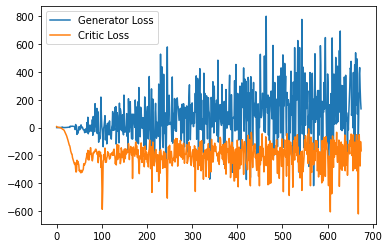

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 29, step 14000: Generator loss: 185.33673477125168, critic loss: -243.5175572563172


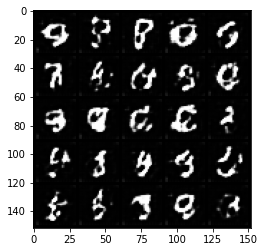

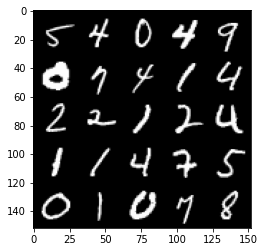

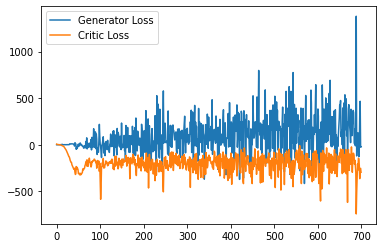

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 30, step 14500: Generator loss: 189.30195573377608, critic loss: -231.1938433269502


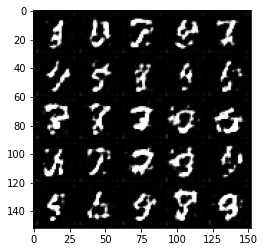

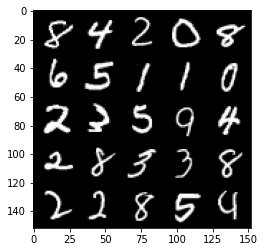

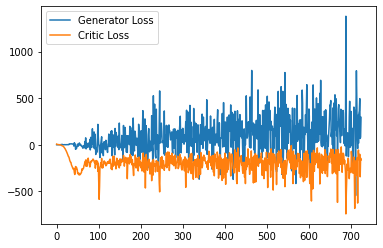

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 31, step 15000: Generator loss: 273.14856692504884, critic loss: -158.17791928100587


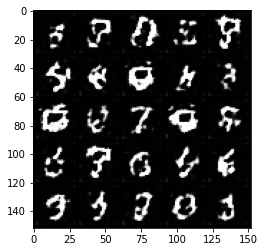

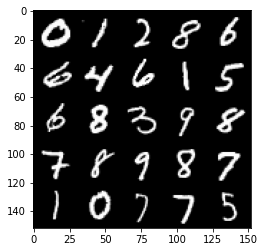

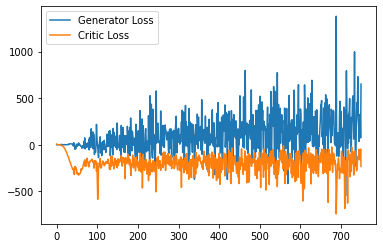

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 33, step 15500: Generator loss: 248.46884392380716, critic loss: -238.4277571437836


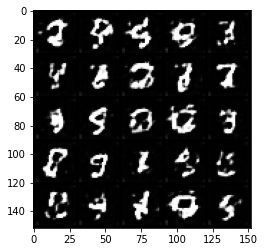

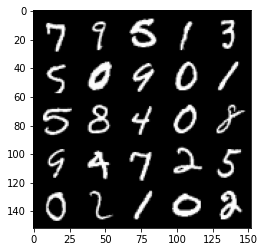

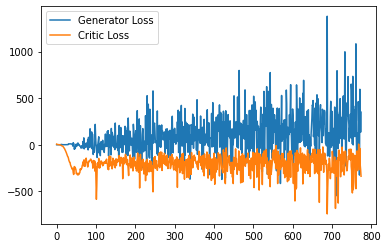

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 34, step 16000: Generator loss: 221.65447679185868, critic loss: -175.27051919803606


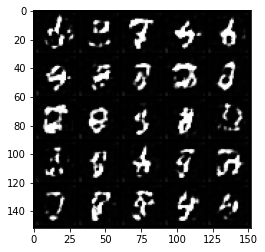

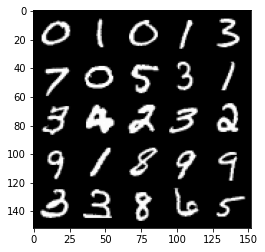

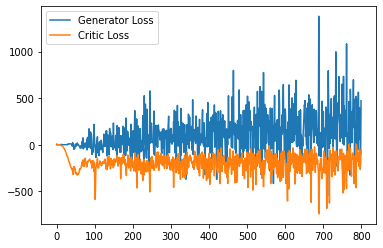

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 35, step 16500: Generator loss: 253.51264949560166, critic loss: -167.34046531982435


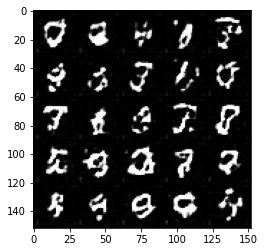

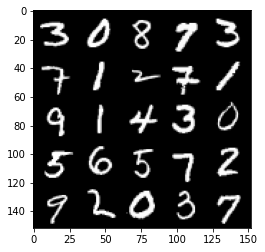

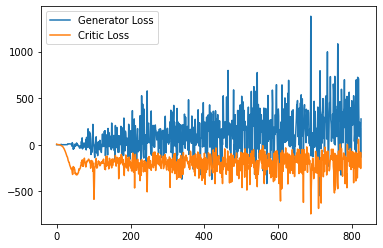

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 36, step 17000: Generator loss: 248.37586431789398, critic loss: -196.27675892524726


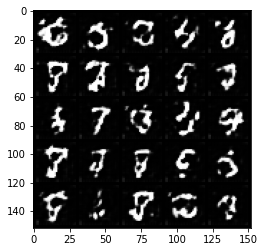

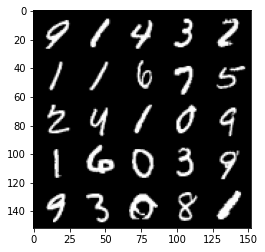

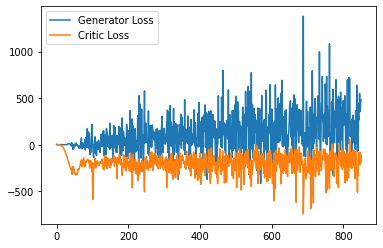

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 37, step 17500: Generator loss: 214.71496093082428, critic loss: -185.07981811218255


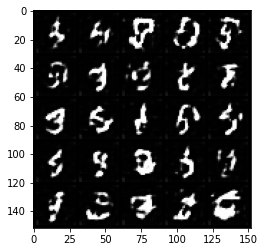

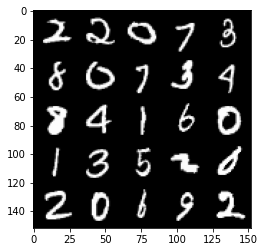

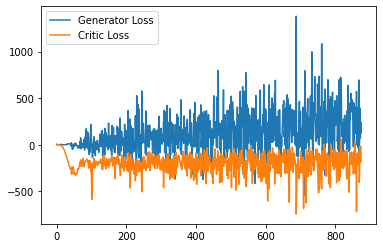

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 38, step 18000: Generator loss: 180.23239593839645, critic loss: -202.18051024131768


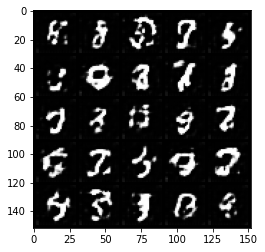

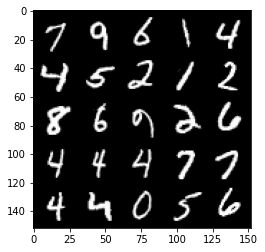

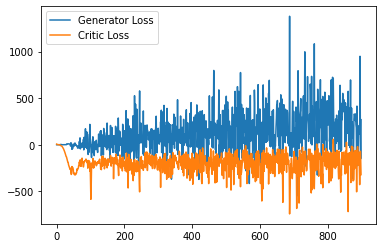

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 39, step 18500: Generator loss: 263.3883991003037, critic loss: -274.43556129455544


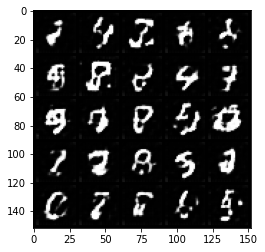

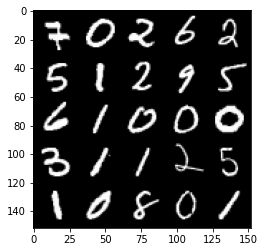

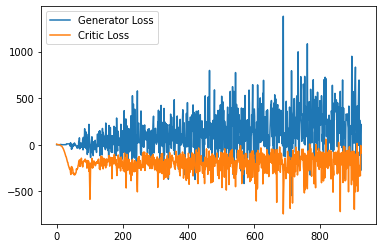

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 40, step 19000: Generator loss: 216.3032230911255, critic loss: -191.0718747455596


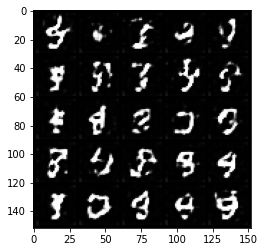

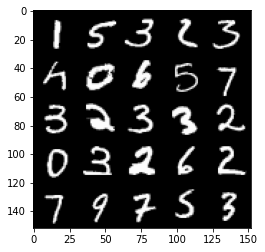

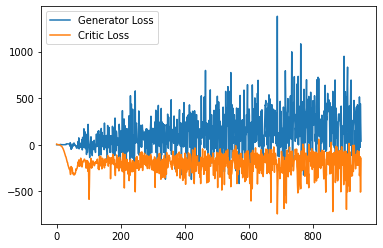

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 41, step 19500: Generator loss: 299.4560481672287, critic loss: -171.85080590820314


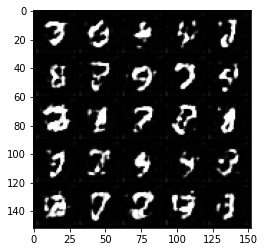

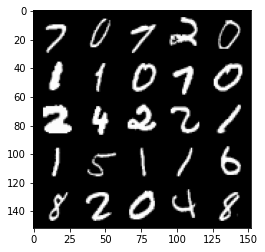

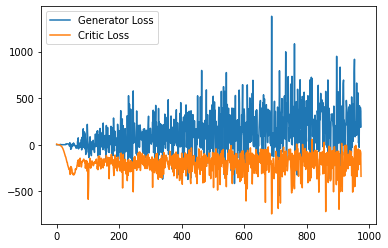

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 42, step 20000: Generator loss: 228.43317721533776, critic loss: -221.3723430934908


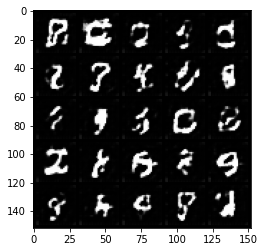

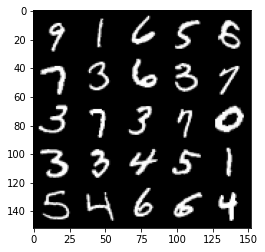

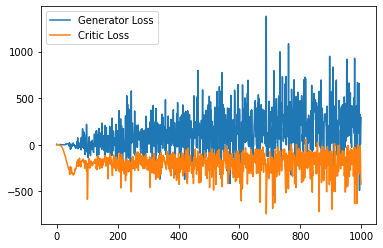

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 43, step 20500: Generator loss: 291.2964188287258, critic loss: -201.29952842140185


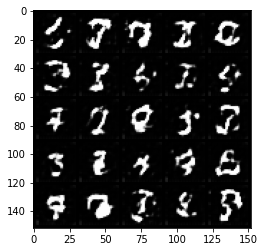

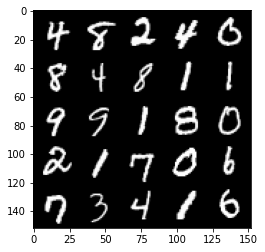

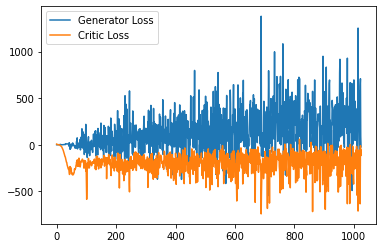

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 44, step 21000: Generator loss: 251.37309470033645, critic loss: -235.8395848503112


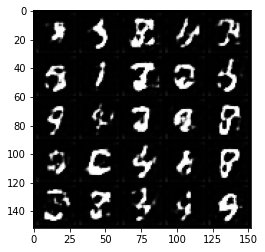

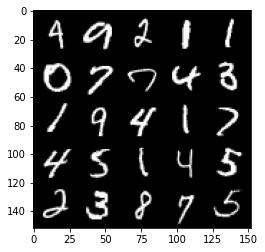

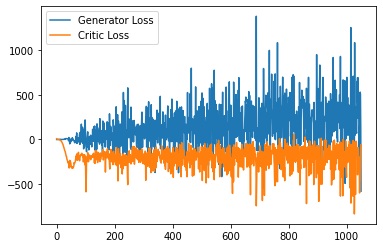

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 45, step 21500: Generator loss: 288.0733573660851, critic loss: -229.57450984611512


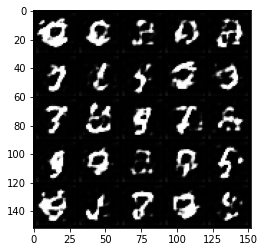

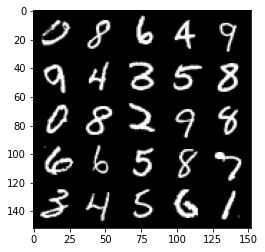

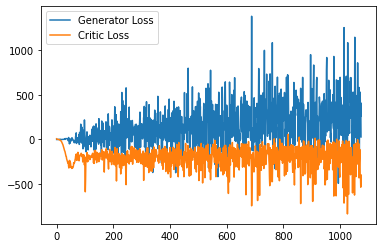

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 46, step 22000: Generator loss: 196.2011605052948, critic loss: -211.28575360412609


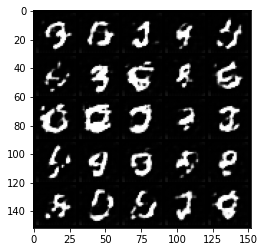

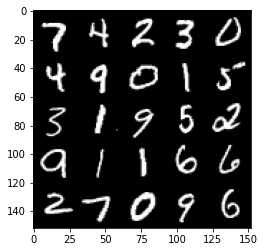

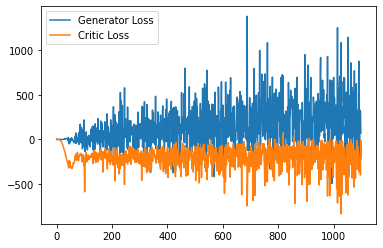

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 47, step 22500: Generator loss: 239.9007876484394, critic loss: -208.68294872589098


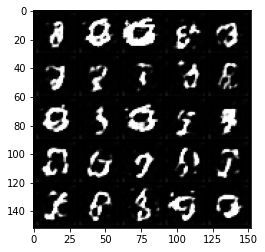

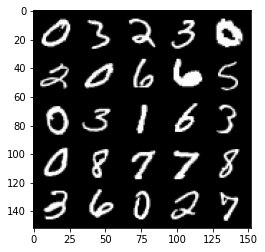

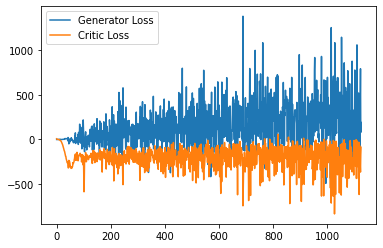

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 49, step 23000: Generator loss: 241.62436007273197, critic loss: -219.38160266647324


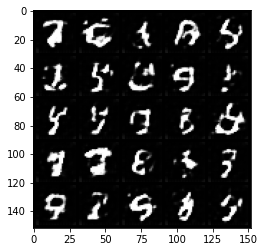

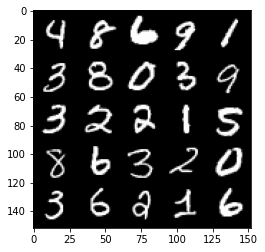

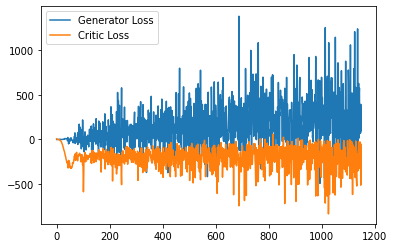

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 50, step 23500: Generator loss: 252.95509695148468, critic loss: -211.45421366996766


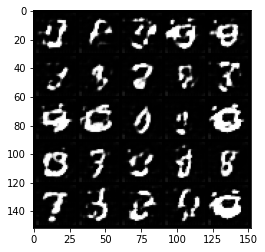

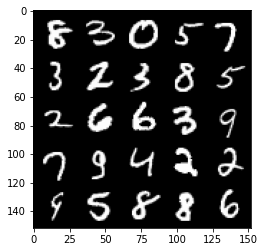

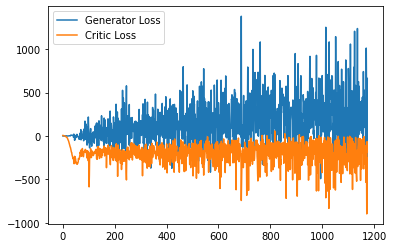

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 51, step 24000: Generator loss: 231.57562903165817, critic loss: -256.89634166412355


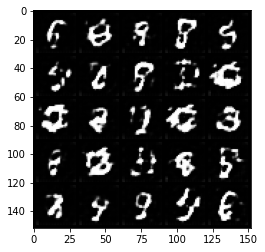

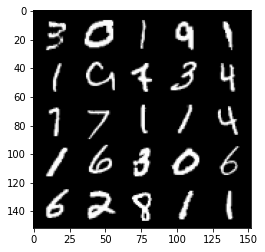

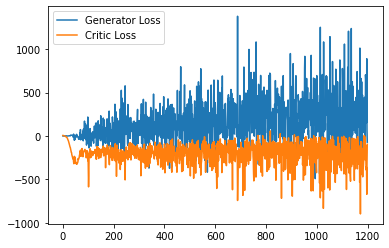

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 52, step 24500: Generator loss: 209.61569495773315, critic loss: -310.91620606880167


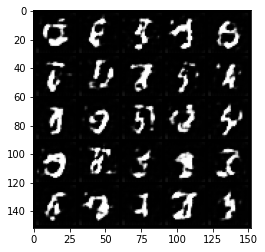

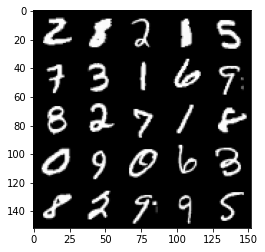

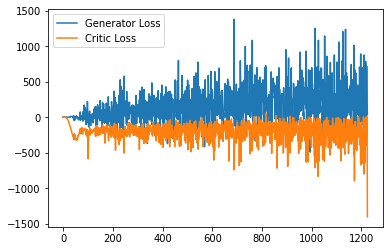

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 53, step 25000: Generator loss: 184.1086737203598, critic loss: -183.09926486244183


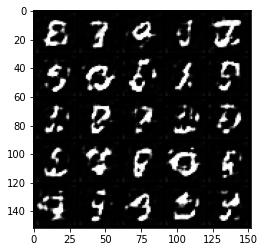

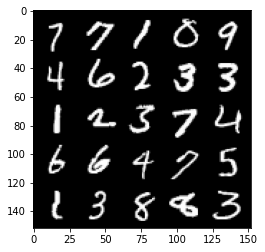

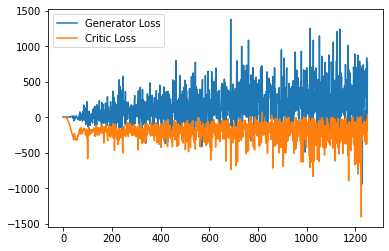

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 54, step 25500: Generator loss: 198.59723931884767, critic loss: -218.95020573577855


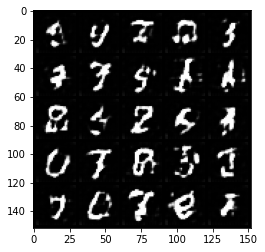

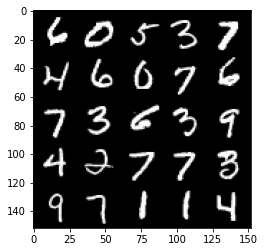

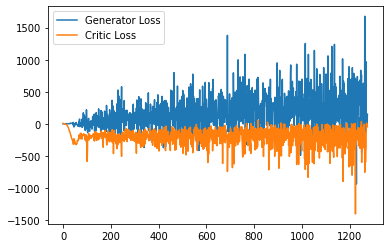

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 55, step 26000: Generator loss: 143.14123293590546, critic loss: -196.40086314239514


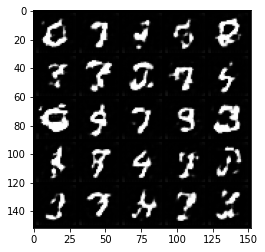

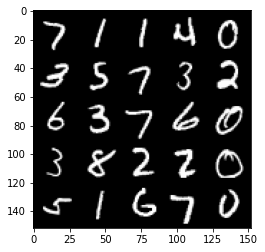

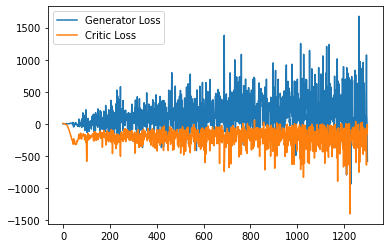

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 56, step 26500: Generator loss: 185.1540789718628, critic loss: -190.30638210639952


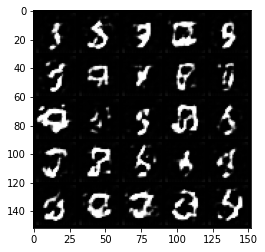

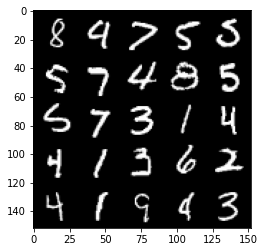

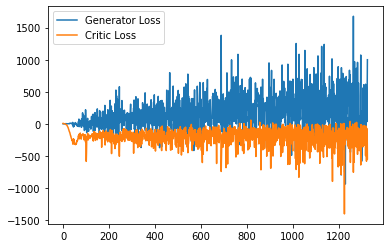

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 57, step 27000: Generator loss: 113.71595546579361, critic loss: -182.06946995468152


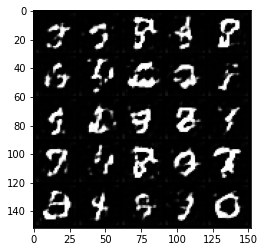

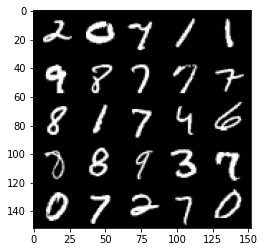

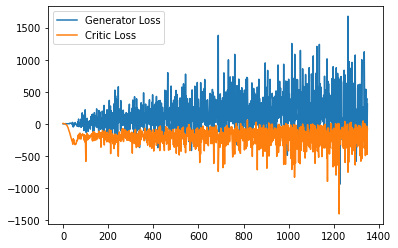

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 58, step 27500: Generator loss: 242.04558906936646, critic loss: -181.95523105087264


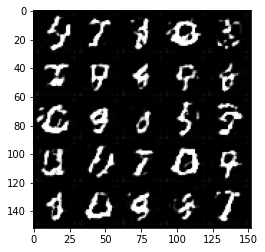

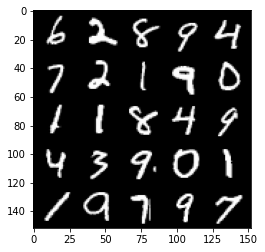

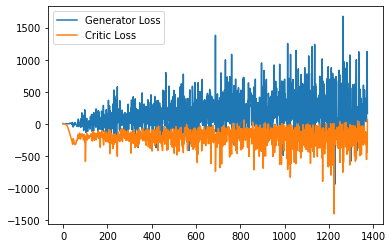

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 59, step 28000: Generator loss: 133.4039685382843, critic loss: -167.31843786220546


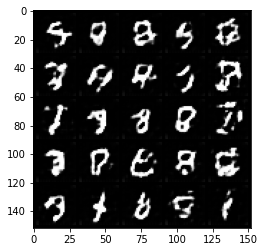

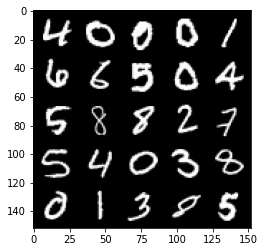

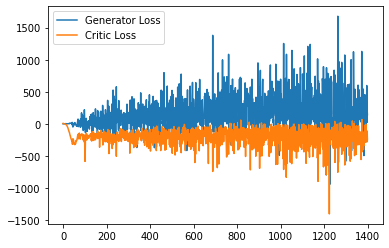

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 60, step 28500: Generator loss: 145.09133099031448, critic loss: -256.59256231803886


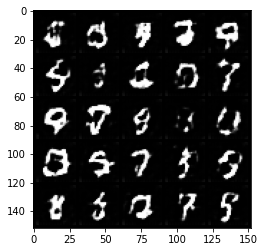

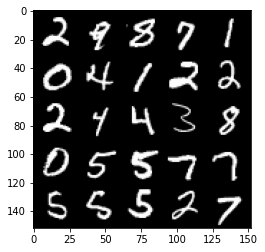

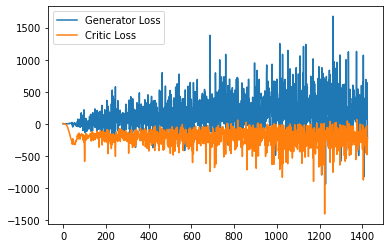

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 61, step 29000: Generator loss: 115.66738104963302, critic loss: -224.5839728603362


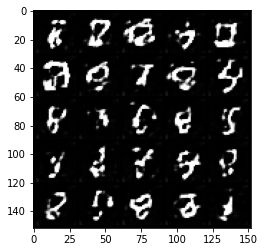

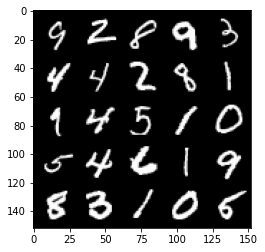

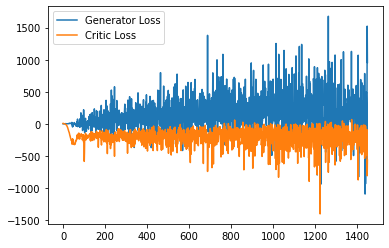

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 62, step 29500: Generator loss: 47.55999902248382, critic loss: -169.6275116744994


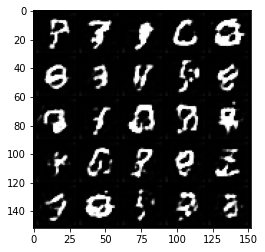

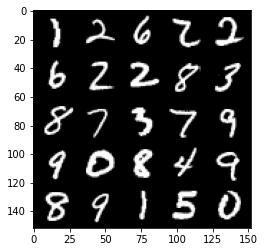

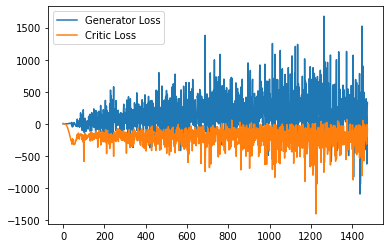

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 63, step 30000: Generator loss: 156.72254171180725, critic loss: -206.61345466499327


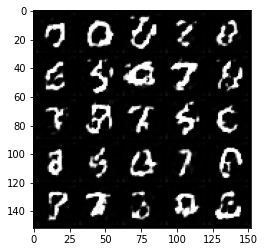

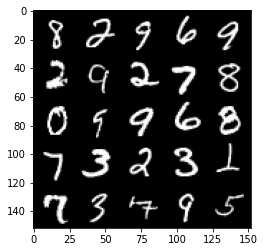

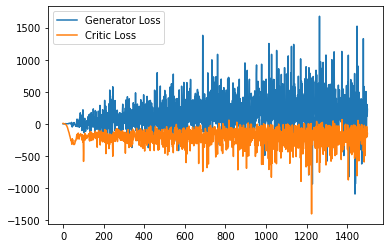

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 65, step 30500: Generator loss: 210.66381240272523, critic loss: -243.01212165832501


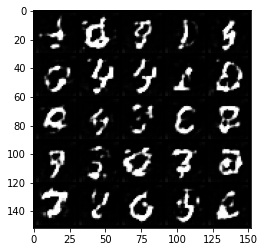

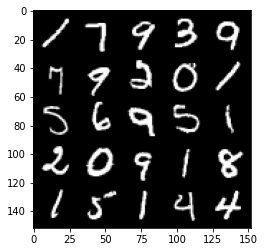

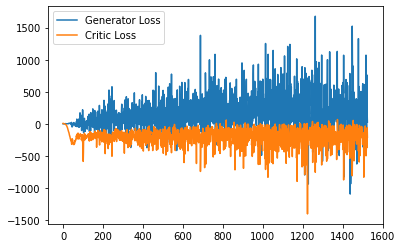

In [20]:
gen_losses = []
crit_losses = []
cur_step = 0

for epoch in range(n_epochs):
    for real,_ in tqdm(dataloader):
        cur_batch_len = len(real)
        real = real.to(device)
        mean_loss_critic = 0.0
        for _ in range(n_critic) :
            critic_opt.zero_grad()

            fake_noise = get_noise(cur_batch_len,z_dim,device)
            fake = gen(fake_noise)
            crit_fake_predict = critic(fake.detach())
            crit_real_predict = critic(real)

            epsilon = torch.randn(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(critic,real, fake, epsilon)
            gp = gradient_penalty(gradient)

            crit_loss = get_critic_loss(crit_real_predict,crit_fake_predict,gp,g_weight)
            mean_loss_critic += crit_loss.item() / n_critic
            # Update gradients
            crit_loss.backward(retain_graph=True)

            critic_opt.step()

        crit_losses.append(mean_loss_critic)

        #update G
        #==================
        gen_opt.zero_grad()

        fake_noise = get_noise(cur_batch_len,z_dim,device)
        fake = gen(fake_noise)
        crit_fake_predict = critic(fake)

        gen_loss = get_gen_loss(crit_fake_predict)
        gen_loss.backward()

        gen_opt.step()
        #==================

        gen_losses.append(gen_loss.item())

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(gen_losses[-display_step:]) / display_step
            crit_mean = sum(crit_losses[-display_step:]) / display_step
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            num_examples = (len(gen_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(gen_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(crit_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Critic Loss"
            )
            plt.legend()
            plt.show()
            torch.save({"generator": gen.state_dict()}, "/content/drive/MyDrive/Generative In Action/ImplicitModel/GAN/src/CGAN-config/pretrained_generator.pth")

        cur_step += 1